In [4]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim.lr_scheduler import StepLR

In [5]:
# Set device to GPU index 4
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [6]:
class Multiscale1DFitter(nn.Module):

    def __init__(self, function, x_data, input_channels, num_params, scaler=None,
                 post_processing=None, device="cuda", loops_scaler=None, **kwargs):
        self.input_channels = input_channels
        self.scaler = scaler
        self.function = function
        self.x_data = x_data
        self.post_processing = post_processing
        self.device = device
        self.num_params = num_params
        self.loops_scaler = loops_scaler

        super().__init__()

        # Input block of 1d convolution
        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        # Fully connected block
        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        # 2nd block of 1d-conv layers
        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        # Flatten layer
        self.flatten_layer = nn.Flatten()

        # Final embedding block
        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 16),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, self.num_params),
        )

    def forward(self, x, n=-1):
        x = torch.swapaxes(x, 1, 2)  # Swap axes 1 and 2
        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))
        xfc = self.hidden_xfc(xfc)

        x = torch.reshape(x, (n, 2, 128))
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)

        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)
        unscaled_param = embedding

        if self.scaler is not None:
            unscaled_param = (embedding * torch.tensor(self.scaler.var_ ** 0.5).to(self.device)
                              + torch.tensor(self.scaler.mean_).to(self.device))
        else:
            unscaled_param = embedding

        fits = self.function(unscaled_param, self.x_data, device=self.device)
        out = fits

        if self.post_processing is not None:
            out = self.post_processing.compute(fits)
        else:
            out = fits

        if self.loops_scaler is not None:
            out_scaled = (out - torch.tensor(self.loops_scaler.mean).to(self.device)) / torch.tensor(self.loops_scaler.std).to(self.device)
        else:
            out_scaled = out

        return out_scaled, unscaled_param

In [4]:
'''
def fit_with_batch_y_data(model, optimizer, loss_func, x_data, y_data, num_epochs=100, batch_size=32):
    model.train()
    num_samples = x_data.size(0)
    # y_data = y_data/100

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for i in range(0, num_samples, batch_size):
            x_batch = x_data[i:i+batch_size]
            y_batch = y_data[i:i+batch_size]

            optimizer.zero_grad()
            outputs, _ = model(y_batch, n=len(y_batch))

            loss = loss_func(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(y_batch)

        epoch_loss /= num_samples

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
'''

In [39]:
def fit_with_batch_x_data(model, optimizer, loss_func, x_data, y_data, num_epochs=100, batch_size=32):
    model.train()
    num_samples = x_data.size(0)

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for i in range(0, num_samples, batch_size):
            x_batch = x_data[i:i+batch_size]
            y_batch = y_data[i:i+batch_size]
            optimizer.zero_grad()
            outputs, _ = model(x_batch)
            loss = loss_func(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * len(x_batch)

        epoch_loss /= num_samples

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

In [8]:
def linear_function(params, x, device='cuda'):
    slope = params[0] #params[:, 0].type(torch.float)#.unsqueeze(1)
    intercept = params[1] #params[:, 1].type(torch.float)#.unsqueeze(1)
    y = slope * x + intercept
    return y

In [6]:
linear_function(torch.tensor([[1,2,3,4,5],[1,2,3,45,5]]), torch.tensor([1,2,2,34, 5]))

tensor([  2,   6,   9, 181,  30])

In [158]:
def generate_linear_data(number_of_curves = 32, num_samples=100, x_range=10, m_range=10, b_range=10, noise_std=1.0):
    slopes = torch.tensor(np.random.uniform(-m_range, m_range, number_of_curves))
    intercepts = torch.tensor(np.random.uniform(-b_range, b_range, number_of_curves))
    x_data = np.random.uniform(-x_range, x_range, num_samples)    
    y_data = slopes.unsqueeze(-1) * x_data + intercepts.unsqueeze(-1)
    #linear_function(torch.stack((slopes,intercepts)), x_data) + np.random.normal(noise_std, num_samples)
    print(y_data.shape)
    
    x_data = torch.tensor(x_data, dtype=torch.float32).unsqueeze(1)
    y_data = torch.tensor(y_data, dtype=torch.float32).unsqueeze(1)
    
    return x_data, y_data, slopes, intercepts

In [159]:
x_data, y_data, slopes, intercepts = generate_linear_data()


torch.Size([32, 100])


/tmp/ipykernel_3006795/1135501554.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_data = slopes.unsqueeze(-1) * x_data + intercepts.unsqueeze(-1)
/tmp/ipykernel_3006795/1135501554.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y_data, dtype=torch.float32).unsqueeze(1)


In [160]:
y_data.shape

torch.Size([32, 1, 100])

In [110]:
def generate_batch_data(batch_size=32, num_samples=100, x_range=10, m_range=10, b_range=10, noise_std=1.0):
    batch_x = []
    batch_y = []
    slopes_t = []
    intercepts_t = []

    
    for _ in range(batch_size):
        slopes = torch.tensor(np.random.uniform(-m_range, m_range, num_samples))
        intercepts = torch.tensor(np.random.uniform(-b_range, b_range, num_samples))
        x = np.random.uniform(-x_range, x_range, num_samples)
        y = linear_function(torch.stack((slopes,intercepts)), x)#slopes*x + intercepts + torch.rand(num_samples)*noise_std #linear_function(torch.stack((slopes,intercepts)), x_data)
        
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        batch_x.append(x)
        batch_y.append(y)
        slopes_t.append(slopes)
        intercepts_t.append(intercepts)
    
    batch_x = torch.stack(batch_x)
    batch_y = torch.stack(batch_y)
    
    return batch_x, batch_y, slopes_t, intercepts_t

In [116]:
x_data, y_data, m, b = generate_batch_data()
x_data.shape, y_data.shape

/tmp/ipykernel_3006795/2347689592.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = slope * x + intercept
/tmp/ipykernel_3006795/858176006.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)


(torch.Size([32, 100, 1]), torch.Size([32, 100, 1]))

/tmp/ipykernel_3006795/1949054914.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_line = slope * x_line + intercept


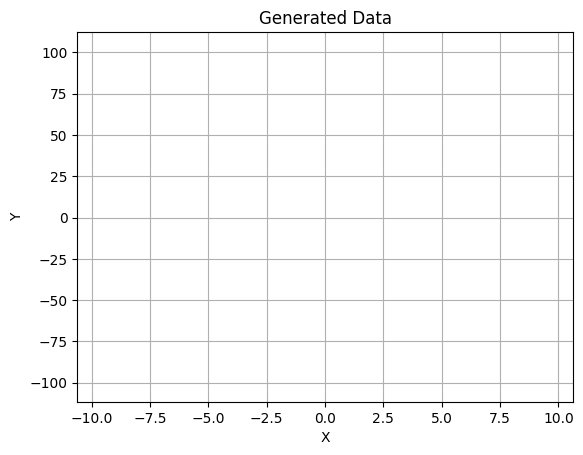

In [168]:
x_data_np = x_data.numpy()
y_data_np = y_data.numpy()
for i in range(32):
    for slope, intercept in zip(m[i], b[i]):
        x_line = np.linspace(np.min(x_data_np[i]), np.max(x_data_np[i]), 100)
        y_line = slope * x_line + intercept
        plt.plot(x_line, y_line)#, label=f'Batch {i+1}')

plt.title('Generated Data')
plt.xlabel('X')
plt.ylabel('Y')
#plt.legend()
plt.grid(True)
plt.show()

In [125]:
x_data.shape, y_data.shape

(torch.Size([32, 100, 1]), torch.Size([100, 1]))

In [133]:
model = Multiscale1DFitter(function=linear_function, x_data=x_data, input_channels=1, num_params=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()

In [148]:
y_data.shape

torch.Size([100, 1])

In [166]:
dataset = TensorDataset(y_data.swapaxes(1,2))
dataloader = DataLoader(dataset, 32)

In [167]:
model.train()
num_samples = x_data.size(0)
for epoch in range(100):
    epoch_loss = 0.0
    for batch in dataloader:
        y = batch[0]
        print(y.shape)
        optimizer.zero_grad()
        outputs, _ = model(y)
        loss = loss_func(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(y)
    epoch_loss /= num_samples
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{100}], Loss: {epoch_loss:.4f}')

torch.Size([32, 100, 1])


/home/cymberly/miniconda3/envs/fitter/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 100, 1])) that is different to the input size (torch.Size([32, 100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
Epoch [10/100], Loss: 360.2294
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
Epoch [20/100], Loss: 360.0947
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
torch.Size([32, 100, 1])


KeyboardInterrupt: 

In [ ]:
#fit_with_batch_y_data(model, optimizer, loss_func, x_data, y_data)

In [135]:
fit_with_batch_x_data(model, optimizer, loss_func, x_data, y_data)

/home/cymberly/miniconda3/envs/fitter/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (100) must match the size of tensor b (32) at non-singleton dimension 1

In [ ]:
def evaluate(model, loss_func, x_data, y_data, device='cuda'):
    model.eval()
    x_data = x_data.to(device)
    y_data = y_data.to(device)
    with torch.no_grad():
        outputs, _ = model(x_data, n=len(x_data))
        loss = loss_func(outputs, y_data)
        print(f'Validation Loss: {loss:.4f}')        

In [ ]:
x_val, y_val, _, _ = generate_linear_data()
x_val = x_val.view(1, 1, -1)
evaluate(model, loss_func,x_val, y_val)

In [ ]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 10, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(10, 1) 

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [ ]:
def fit_batch_sched(model, optimizer, loss_func, scheduler, x_data, y_data, num_epochs=100, batch_size=32):
    model.train()
    num_samples = x_data.size(0)

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for i in range(0, num_samples, batch_size):
            x_batch = x_data[i:i+batch_size]
            y_batch = y_data[i:i+batch_size]

            optimizer.zero_grad()
            outputs, _ = model(x_batch, n=len(x_batch))

            loss = loss_func(outputs, y_batch)
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item() * len(x_batch)

        epoch_loss /= num_samples

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

def fit(model, optimizer, loss_func, scheduler, x_data, y_data, num_epochs=100):
    for epoch in range(num_epochs):
        out_scaled, unscaled_param = model(x_data)
        loss = loss_func(out_scaled, y_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
# fit_batch_sched(model, optimizer, loss_func, scheduler, x_data, y_data)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
# fit(model, optimizer, loss_func, scheduler, x_data, y_data)